## Project: Super Mario Bros with a Double Deep Q-Network

### Note: If you want to Run project you need to upload three files and Run it 
### 1. SuperMarioBros-1-1-v0_DuelingDDQN_Q_STEP
### 2. SuperMarioBros-1-1-v0_DuelingDDQN_Q_TARGET
### 3. train_metadata-1-1.pkl

### Team: 
### 1. Omar Ahmed Mohamed Ahmed
### 2. AlHassan Gamal 
### 3. Alaa El-sayed 

In [ ]:
%%capture
!pip install gym_super_mario_bros

In [ ]:
ROOT = '/content'

In [ ]:
import os
import cv2
import gym
import time
import collections

import numpy as np
import torch as T
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm

import gym_super_mario_bros
from nes_py.wrappers import JoypadSpace
from gym_super_mario_bros.actions import SIMPLE_MOVEMENT

%matplotlib inline

In [ ]:
T.cuda.get_device_name()

'Tesla T4'

## **Wrappers**

In [ ]:
# PREPROCESS EACH FRAME
class PreprocessFrames(gym.ObservationWrapper):
    """
    PREPROCESSES EACH FRAME (input = (rows, columns, 3)) [0-255]
    1. resize image                             -   (new_rows, new_columns, 1)       [0-255]
    2. convert to nparray                       -   array(new_rows, new_columns, )  [0-255]
    3. move axis(reshape)                       -   array(1, new_rows, new_columns)  [0-255]
    3. scale values from 0-1                    -   array(1, new_rows, new_columns)  [0.0-1.0]
    """
    def __init__(self, env, new_observation_shape):
        super().__init__(env)
        self.new_observation_shape = new_observation_shape
        self.observation_space = gym.spaces.Box(low=0.0, high=1.0, shape=self.new_observation_shape, dtype=np.float32)
    
    def observation(self, observation):
        temp_frame = cv2.cvtColor(observation, cv2.COLOR_RGB2GRAY)
        temp_frame = cv2.resize(temp_frame, self.new_observation_shape[1:], interpolation=cv2.INTER_AREA)
        new_observation = np.array(temp_frame, dtype=np.float32).reshape(self.new_observation_shape)
        new_observation = new_observation / 255.0 
        return new_observation

# TO BE CALLED ON EACH SINGLE IMAGE (AFTER PREPROCESS)
class CustomStep(gym.Wrapper):
    """
    OVERRIDES step() & reset()
    1. repeats same action in 'n' skipped frames to compute faster.
    2. takes maximum of 2 frames.
    """
    def __init__(self, env, frame_skip):
        super().__init__(env)
        self.frame_skip = frame_skip
        self.observation_shape = env.observation_space.shape
        self.observation_buffer = np.zeros_like((2, self.observation_shape))

    def reset(self):
        observation = self.env.reset()
        self.observation_buffer = np.zeros_like((2, self.observation_shape))
        self.observation_buffer[0] = observation
        return observation

    # RETURN FRAME_SKIPPED FRAMES
    def step(self, action):
        total_reward = 0.0
        done = False

        for frame in range(self.frame_skip):
            observation, reward, done, info = self.env.step(action)
            total_reward += reward

            idx = frame % 2
            self.observation_buffer[idx] = observation

            if done: break

        observation_max = np.maximum(self.observation_buffer[0], self.observation_buffer[1])
        return observation_max, total_reward, done, info


# STACK OBSERVATIONS
class StackFrames(gym.ObservationWrapper):
    """
    STACKS stack_size FRAMES TOGETHER AND RETURNS AS THE 'observation'
    1. on reset() returns first 'observation' STACKED 'stack_size' times
    2. observation() returns current 'observation' STACKED with 'stack_size-1' previous 'observation'
    """
    def __init__(self, env, stack_size):
        super().__init__(env)
        self.observation_space = gym.spaces.Box(
                                    env.observation_space.low.repeat(stack_size, axis=0),
                                    env.observation_space.high.repeat(stack_size, axis=0)
                                 )
        self.stack = collections.deque(maxlen=stack_size)

    def reset(self):
        self.stack.clear()
        observation = self.env.reset()
        for _ in range(self.stack.maxlen):
            self.stack.append(observation)
        observation = np.array(self.stack).reshape(self.observation_space.shape)
        return observation
        
    def observation(self, observation):
        self.stack.append(observation)
        observation = np.array(self.stack).reshape(self.observation_space.shape)
        return observation

class CustomReward(gym.Wrapper):
    def __init__(self, env):
        super().__init__(env)
        self._current_score = 0

    def step(self, action):
        observation, reward, done, info = self.env.step(action)
        reward += (info['score'] - self._current_score) / 40.0
        self._current_score = info['score']
        if done:
            if info['flag_get']:
                reward += 350.0
            else:
                reward -= 50.0
        return observation, reward / 10.0, done, info

In [ ]:
# TIE EVERYTHING TOGETHER
def make_env(env_name, new_observation_shape=(1,96,96), stack_size=4, frame_skip=4):
    env = gym.make(env_name)
    env = JoypadSpace(env, SIMPLE_MOVEMENT)
    env = PreprocessFrames(env, new_observation_shape=new_observation_shape)
    env = CustomStep(env, frame_skip=4)
    env = StackFrames(env, stack_size=stack_size)
    env = CustomReward(env)
    return env

## **ReplayBuffer**

In [ ]:
class ReplayBuffer:
    def __init__(self, mem_size, observation_shape, n_actions):
        self.mem_size = mem_size
        self.mem_counter = 0
        # DATA
        self.states = np.zeros((mem_size, *observation_shape), dtype=np.float32)
        self.actions = np.zeros(mem_size, dtype=np.int64)
        self.rewards = np.zeros(mem_size, dtype=np.int64)
        self.states_ = np.zeros((mem_size, *observation_shape), dtype=np.float32)
        self.terminals = np.zeros(mem_size, dtype=bool)

    # STORE TRANSITIONS IN BUFFER
    def store_transition(self, state, action, reward, state_, done):
        index = self.mem_counter % self.mem_size
        self.states[index] = state
        self.actions[index] = action
        self.rewards[index] = reward
        self.states_[index] = state_
        self.terminals[index] = done # 1 if 'done' else 0
        self.mem_counter += 1

    # UNIFORMLY SAMPLES 'BUFFER' AND RETURNS A 'BATCH' OF batch_size
    def sample_batch(self, batch_size):
        max_index = min(self.mem_counter, self.mem_size)
        batch_indices = np.random.choice(max_index, batch_size, replace=False)
        states = self.states[batch_indices]
        actions = self.actions[batch_indices]
        rewards = self.rewards[batch_indices]
        states_ = self.states_[batch_indices]
        terminals = self.terminals[batch_indices]
        return (states, actions, rewards, states_, terminals)

## **Network**

In [ ]:
class DuelingDeepQNetwork(nn.Module):
    def __init__(self, lr, observation_shape, n_actions, model_name, model_dir):
        super().__init__()
        self.model_dir = model_dir
        self.model_file = os.path.join(self.model_dir, model_name)
        # CNN
        self.conv1 = nn.Conv2d(observation_shape[0], 32, kernel_size=8, stride=4)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=4, stride=2)
        self.conv3 = nn.Conv2d(64, 64, kernel_size=3, stride=1)
        # CNN -> ANN
        fc_input_dims = self.caculate_conv_output_dims(observation_shape)
        # ANN
        self.fc1 = nn.Linear(fc_input_dims, 512)
        # DUELING
        self.V = nn.Linear(512, 1)
        self.A = nn.Linear(512, n_actions)
        # UTILS
        self.device = T.device('cuda:0' if T.cuda.is_available() else 'cpu')
        self.optimizer = optim.RMSprop(self.parameters(), lr=lr)
        self.loss = nn.SmoothL1Loss() # CUSTOM LOSS IN AGENT
        self.to(self.device)
    
    def forward(self, state):
        t = F.relu(self.conv1(state))
        t = F.relu(self.conv2(t))
        t = F.relu(self.conv3(t))
        t = F.relu(self.fc1(t.reshape(t.shape[0], -1)))
        V = self.V(t)
        A = self.A(t)
        return V,A

    def caculate_conv_output_dims(self, observation_shape):
        dims = T.zeros((1, *observation_shape))
        dims = self.conv1(dims)
        dims = self.conv2(dims)
        dims = self.conv3(dims)
        return int(np.prod(dims.shape))

    def save_model(self):
        print("[INFO] Saving model")
        checkpoint = {
            'model_state_dict': self.state_dict(),
            'optimizer_state_dict' : self.optimizer.state_dict()
        }
        T.save(checkpoint, self.model_file)
    
    def load_model(self, cpu=False):
        print("[INFO] Loading model")
        
        map_location = T.device('cpu') if (cpu) else None
        
        checkpoint = T.load(self.model_file, map_location=map_location)
        self.load_state_dict(checkpoint['model_state_dict'])
        self.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

## **Agent**

In [ ]:
class DuelingDDQNAgent:
    def __init__(self, observation_shape, n_actions, lr, gamma, epsilon, epsilon_min, epsilon_decay, mem_size,  batch_size, 
                 Q_TARGET_replace_interval, initial_exploration_steps, algo_name, env_name, model_dir):
        self.observation_shape = observation_shape
        self.n_actions = n_actions
        self.LR = lr
        self.GAMMA = gamma
        self.EPSILON = epsilon
        self.epsilon_min = epsilon_min
        self.epsilon_decay = epsilon_decay

        # MEM PARAMS
        self.mem_size = mem_size
        self.batch_size = batch_size
        self.memory = ReplayBuffer(mem_size, observation_shape, n_actions)

        # MODEL PARAMS
        self.initial_exploration_steps = initial_exploration_steps
        self.exploration_counter = 0
        self.learn_counter = 0 # TO UPDATE TARGET NETWORK
        self.algo_name = algo_name
        self.env_name = env_name
        self.model_dir = model_dir
        self.Q_TARGET_replace_interval = Q_TARGET_replace_interval
        # Q1
        self.Q_STEP = DuelingDeepQNetwork(lr, observation_shape, n_actions,
                              model_name = env_name+'_'+algo_name+'_Q_STEP',
                              model_dir = model_dir)
        # Q2
        self.Q_TARGET = DuelingDeepQNetwork(lr, observation_shape, n_actions,
                              model_name = env_name+'_'+algo_name+'_Q_TARGET',
                              model_dir = model_dir)

    # e-GREEDY POLICY
    def get_action(self, observation, greedy=False):
        if ( (np.random.uniform() >= self.EPSILON) or greedy):
            observation = T.tensor(observation, dtype=T.float32).to(self.Q_STEP.device)
            state = T.unsqueeze(observation, 0)
            _,A = self.Q_STEP(state)
            action = T.argmax(A).item()
        else:
            action = env.action_space.sample()
        return action

    def learn(self):
        if (self.exploration_counter < self.initial_exploration_steps): return # return if not explored enough
        if (self.memory.mem_counter < self.batch_size): return # return if insufficient samples present
        # RESET TARGET NETWORK (every 1000 steps)
        self.update_Q_TARGET()

        states, actions, rewards, states_, terminals = self.sample_batch()
        # PREDICT Q1(s,a)
        v1,a1 = self.Q_STEP(states)
        q1 = v1 + (a1 - a1.mean(dim=1, keepdim=True)) # q - batch_size * n_actions
        indices = np.arange(len(actions))
        q1_preds = q1[indices,actions]

        # GET V1,A2(s_,A) and V2,A2(s_,A)
        v1_, a1_ = self.Q_STEP(states_)
        v2_, a2_ = self.Q_TARGET(states_)
        # GET Q1(s_,A) and Q2(s_,A)
        q1_ = v1_ + (a1_ - a1_.mean(dim=1, keepdim=True))
        q2_ = v2_ + (a2_ - a2_.mean(dim=1, keepdim=True))
        # argmax(Q1(s_,A)) - (max)a_
        # Q2(s_, (max)a_) - TARGETS
        a_ = T.argmax(q1_, dim=1)
        indices = np.arange(len(a_))
        q2_next = q2_[indices, a_]
        q2_next[terminals] = 0.0                      # Q2(s_) = 0 where terminal=1
        q2_targets = rewards + (self.GAMMA * q2_next)

        # CALC LOSS & BACKPROP
        loss = self.Q_TARGET.loss(q1_preds, q2_targets).to(self.Q_STEP.device)
        # loss = loss.mean()

        self.Q_STEP.optimizer.zero_grad()
        loss.backward()
        self.Q_STEP.optimizer.step()

        self.learn_counter += 1
        self.decay_epsilon()

    def update_Q_TARGET(self):
        if ((self.learn_counter % self.Q_TARGET_replace_interval) == 0):
            self.Q_TARGET.load_state_dict(self.Q_STEP.state_dict())
    
    def decay_epsilon(self):
        if (self.EPSILON > self.epsilon_min):
            self.EPSILON -= self.epsilon_decay
        else:
            self.EPSILON = self.epsilon_min
    
    def store_transition(self, state, action, reward, state_, done):
        self.memory.store_transition(state, action, reward, state_, done)

    def sample_batch(self):
        states, actions, rewards, states_, terminals = self.memory.sample_batch(self.batch_size)
        states = T.tensor(states).to(self.Q_STEP.device)
        actions = T.tensor(actions).to(self.Q_STEP.device)
        rewards = T.tensor(rewards).to(self.Q_STEP.device)
        states_ = T.tensor(states_).to(self.Q_STEP.device)
        terminals = T.tensor(terminals).to(self.Q_STEP.device)
        return states, actions, rewards, states_, terminals
        
    def save_models(self):
        self.Q_STEP.save_model()
        self.Q_TARGET.save_model()
    
    def load_models(self, cpu=False):
        self.Q_STEP.load_model(cpu)
        self.Q_TARGET.load_model(cpu)

## **Training**

In [ ]:
env_name = 'SuperMarioBros-1-1-v0'
env = make_env(env_name)
# ROOT = './'

# SIMPLE_MOVEMENT = [
#     ['NOOP'],
#     ['right'],
#     ['right', 'A'],
#     ['right', 'B'],
#     ['right', 'A', 'B'],
#     ['A'],
#     ['left'],
# ]

<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


In [ ]:
agent = DuelingDDQNAgent(observation_shape=env.observation_space.shape,
                         n_actions=env.action_space.n,
                         lr=1e-4,
                         gamma=0.99,
                         epsilon=1.0,
                         epsilon_min=0.01,
                         epsilon_decay=1e-6,
                         mem_size=20000,
                         batch_size=32,
                         Q_TARGET_replace_interval=1000,
                         initial_exploration_steps = 10000,
                         algo_name='DuelingDDQN',
                         env_name=env_name,
                         model_dir=ROOT)

In [ ]:
# ## IF NEW TRAIN CYCLE
# N_EPISODES = 10000

# best_reward = -np.inf
# episode_rewards, episode_lengths, episode_epsilons, mean_rewards = [],[],[],[]

## IF SERIALIZED OBJECT EXISTS
train_metadata = T.load((ROOT+"/train_metadata-1-1.pkl"))

N_EPISODES = 1000 - train_metadata["episode_n"]
best_reward = train_metadata["best_reward"]
episode_rewards = train_metadata["episode_rewards"]
episode_lengths = train_metadata["episode_lengths"]
episode_epsilons = train_metadata["episode_epsilons"]
mean_rewards = train_metadata["mean_rewards"]

agent.EPSILON = episode_epsilons[len(episode_epsilons)-1]
agent.load_models()

[INFO] Loading model
[INFO] Loading model


In [ ]:
for episode_n in tqdm(range(N_EPISODES)):
    total_reward, total_moves = 0,0

    done = False
    observation = env.reset()

    while not done:
        agent.exploration_counter += 1
        # e-GREEDY ACTION
        action = agent.get_action(observation)
        observation_, reward, done, _ = env.step(action)

        total_reward += reward
        total_moves += 1

        # STORE DATA & LEARN
        agent.store_transition(observation, action, reward, observation_, done)
        agent.learn()

        observation = observation_

    episode_rewards.append(total_reward)
    episode_lengths.append(total_moves)
    episode_epsilons.append(agent.EPSILON)

    mean_reward = np.mean(episode_rewards[-100:])
    mean_rewards.append(mean_reward)
    
    if(mean_reward > best_reward):
        agent.save_models()
        best_reward = mean_reward

        train_metadata = {
            'episode_n': episode_n,
            'best_reward': best_reward,
            'mean_rewards': mean_rewards,
            'episode_rewards': episode_rewards, 
            'episode_lengths': episode_lengths,
            'episode_epsilons': episode_epsilons
        }
        T.save(train_metadata, (ROOT+"/train_metadata-1-1.pkl"))

    print("ITER: ",episode_n,"\tRWD: ",round(total_reward,2),"\tM_RWD: ",round(mean_reward,2),"\tLEN: ",total_moves,"\tEPS: ",round(agent.EPSILON,4))

  0%|          | 0/960 [00:00<?, ?it/s]

<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


ITER:  0 	RWD:  164.6 	M_RWD:  180.6 	LEN:  162 	EPS:  0.0154
ITER:  1 	RWD:  181.4 	M_RWD:  180.19 	LEN:  181 	EPS:  0.0154
ITER:  2 	RWD:  137.4 	M_RWD:  180.8 	LEN:  147 	EPS:  0.0154
ITER:  3 	RWD:  186.8 	M_RWD:  180.36 	LEN:  186 	EPS:  0.0154
[INFO] Saving model
[INFO] Saving model
ITER:  4 	RWD:  163.3 	M_RWD:  181.01 	LEN:  157 	EPS:  0.0154
ITER:  5 	RWD:  138.4 	M_RWD:  180.71 	LEN:  147 	EPS:  0.0154
[INFO] Saving model
[INFO] Saving model
ITER:  6 	RWD:  179.85 	M_RWD:  181.52 	LEN:  186 	EPS:  0.0154
ITER:  7 	RWD:  136.65 	M_RWD:  180.57 	LEN:  147 	EPS:  0.0154
ITER:  8 	RWD:  137.9 	M_RWD:  180.13 	LEN:  147 	EPS:  0.0154
ITER:  9 	RWD:  188.05 	M_RWD:  180.62 	LEN:  183 	EPS:  0.0154
ITER:  10 	RWD:  172.1 	M_RWD:  180.94 	LEN:  2005 	EPS:  0.0154
ITER:  11 	RWD:  136.15 	M_RWD:  180.53 	LEN:  147 	EPS:  0.0154
ITER:  12 	RWD:  137.9 	M_RWD:  181.32 	LEN:  147 	EPS:  0.0154
ITER:  13 	RWD:  59.65 	M_RWD:  180.02 	LEN:  69 	EPS:  0.0154
ITER:  14 	RWD:  167.65 	M_RWD: 

In [ ]:
# ## MANUAL SAVE
# agent.save_models()

# train_metadata = {
#     'episode_n': len(mean_rewards),
#     'best_reward': best_reward,
#     'mean_rewards': mean_rewards,
#     'episode_rewards': episode_rewards, 
#     'episode_lengths': episode_lengths,
#     'episode_epsilons': episode_epsilons
# }
# T.save(train_metadata, (ROOT+"/train_metadata.pkl"))

[INFO] Saving model
[INFO] Saving model


## **Testing**

In [ ]:
env_name = 'SuperMarioBros-1-1-v0'
env = make_env(env_name)
ROOT = '/content'

agent = DuelingDDQNAgent(observation_shape=env.observation_space.shape,
                         n_actions=env.action_space.n,
                         lr=1e-4,
                         gamma=0.99,
                         epsilon=1.0,
                         epsilon_min=0.01,
                         epsilon_decay=1e-6,
                         mem_size=1,
                         batch_size=1,
                         Q_TARGET_replace_interval=1,
                         initial_exploration_steps = 1,
                         algo_name='DuelingDDQN',
                         env_name=env_name,
                         model_dir=ROOT)

agent.load_models(cpu=True)

[INFO] Loading model
[INFO] Loading model


<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


dict_keys(['episode_n', 'best_reward', 'mean_rewards', 'episode_rewards', 'episode_lengths', 'episode_epsilons'])
ITER:	 932
BEST:	 257.31449999999916


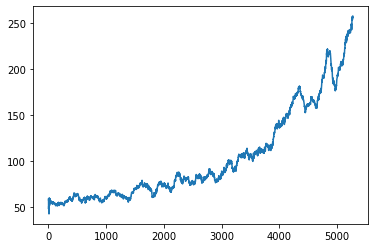

In [ ]:
train_metadata = T.load((ROOT+"/train_metadata-1-1.pkl"))
print(train_metadata.keys())
print("ITER:\t",train_metadata['episode_n'])
print("BEST:\t",train_metadata['best_reward'])

plt.plot(train_metadata['mean_rewards'])

In [ ]:
with T.no_grad():
    total_reward, total_moves = 0,0
    done = False
    observation = env.reset()

    while not done:
        time.sleep(0.05)
        # env.render()

        # e_GREEDY ACTION
        action = agent.get_action(observation, greedy=True)
        observation_, reward, done, _ = env.step(action)

        total_reward += reward
        total_moves += 1

        observation = observation_
    print("RWD: ",total_reward,"\tLEN: ",total_moves)
    # env.close()

<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


RWD:  248.04999999999157 	LEN:  2005


In [ ]:
!pip install colabgymrender==1.0.2

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for colabgymrender: filename=colabgymrender-1.0.2-py3-none-any.whl size=2446 sha256=9a9f7745cfea0f718f0f379dc9ab171c9796123c17cd25e276d8a22dbbfb659d
  Stored in directory: /root/.cache/pip/wheels/1f/56/73/3697080da5fc7b120516aef37d1d1eb2380515ba9e272b8ccd
Successfully built colabgymrender


In [ ]:
!apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1

## Important Note: l have a problem in this cell recorder not Run in this cell but video is upload in the files of colab and l will upload it with Notebook and document

In [ ]:
from colabgymrender.recorder import Recorder

directory = './video'
env = Recorder(env, directory)

obs = env.reset()
done = False

for i in range(10000000):
  action = env.action_space.sample()
  obs, reward, done, info = env.step(action)
env.play()

AttributeError: ignored